# <center>SETTING UP ENVIRONMENT</center>

In [1]:
is_colab = False
import sys

if "google.colab" in sys.modules:
    print("You are running on Google colab")
    is_colab = True
    from google.colab import drive

    drive.mount('/content/drive')
    drive_url = "/content/drive/MyDrive/LSTM-GRU-data/"
    !pip install --upgrade keras
    !pip install --upgrade tensorflow
    !pip install pydot graphviz

else:
    drive_url = ""
    print("You are running on local env")
    is_colab = False


You are running on Google colab
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.15.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import warnings
import keras

warnings.filterwarnings("ignore")
from datetime import datetime
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout, Bidirectional, concatenate, Input, Flatten
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, F1Score, AUC

from sklearn.model_selection import train_test_split
from keras.utils import plot_model


In [3]:
dataset_target = "Dataset/"
img_target = "Img/"
model_checkpoint_target = "Model_checkpoint/"
preprocessed_target = "Preprocessed/"
pretrained_target = "Pretrained/"

# <center>DATA PREPARATION</center>

In [4]:
data = pd.read_csv(drive_url + dataset_target + "cleaned_text_emotion.csv")
# data = data.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

data = data.dropna(subset=['label', 'text'])

data['label'].value_counts()

0    218829
1    165149
Name: label, dtype: int64

In [5]:
# threshold = 160000
# data = data.groupby('label').apply(lambda x: x.sample(n=min(len(x), threshold)))
# data.reset_index(drop=True, inplace=True)
# data['label'].value_counts()

In [6]:
# define features & target
texts = data['text']
labels = data['label']
labels = to_categorical(y=labels, num_classes=2)

# split
# Train (90%), Temp(10%)
Xtrain, Xtemp, y_train, y_temp = train_test_split(texts, labels, test_size=0.1, random_state=0)

# Val(8%), Test(2%)
Xval, Xtest, y_val, y_test = train_test_split(Xtemp, y_temp, test_size=0.2, random_state=1)

print(f"train size: {len(Xtrain)}")
print(f"dev size: {len(Xval)}")
print(f"test size: {len(Xtest)}")

train size: 345580
dev size: 30718
test size: 7680


# <center>TOKENIZE DATA</center>

In [7]:
# Xtrain.to_pickle(drive_url+preprocessed_target+"Xtrain.pkl")

In [8]:
# Xtrain = pd.read_pickle(drive_url+preprocessed_target+"Xtrain.pkl")

In [9]:
# Get a dictionary contain vocabularies
tokenizer = Tokenizer(num_words=None)  # set None to get the largest as possible
tokenizer.fit_on_texts(Xtrain)

In [10]:
# Number of tokens
dic_size = len(tokenizer.word_counts.items())
print(f"Total of word: {dic_size} words")

num_tokens = dic_size + 1

Total of word: 28814 words


#<center>VECTORIZE DATA</center>

In [11]:
seq_X_train = tokenizer.texts_to_sequences(Xtrain)
seq_X_val = tokenizer.texts_to_sequences(Xval)
seq_X_test = tokenizer.texts_to_sequences(Xtest)

In [12]:
# Max length of the sentence
# max_length = np.max(np.array([len(sentence) for sentence in seq_X_train]))
# margin = 10
# max_length = max_length + margin
# max_length

max_length = 65

In [13]:
# Padding
Xtrain = pad_sequences(sequences=seq_X_train, maxlen=max_length, padding="post")
Xval = pad_sequences(sequences=seq_X_val, maxlen=max_length, padding='post')
Xtest = pad_sequences(sequences=seq_X_test, maxlen=max_length, padding='post')


# <center>LOAD PRETRAIN MODEL: WIKI-NEWS-300D-1M BY FASTTEXT</center>

In [14]:
# # ##### Load pretrained embedding layer
# def load_embedding_model(file: str) -> str:
#     """
#     Load word embeddings from a specified file into a dictionary.

#     This function reads word embeddings from the given file and stores them in a dictionary, with words as keys
#     and their corresponding embeddings as values.

#     Parameters:
#         file (str): The path to the file containing word embeddings.

#     Returns:
#         dict: A dictionary where words are keys, and their embeddings are lists of floats.

#     Example:
#         >>> embedding_model = load_embedding_model("pretrained/wiki-news-300d-1M.vec")
#     """
#     embedding_model = {}
#     with open(file, 'r', encoding='utf-8') as f:
#         for line in f:
#             split_line = line.split()
#             word = split_line[0]
#             embedding = [float(value) for value in split_line[1:]]
#             embedding_model[word] = embedding
#     return embedding_model


# embedding_index_fasttext = load_embedding_model(file=drive_url + pretrained_target + "wiki-news-300d-1M.vec")
# print('found %s word vectors in loaded fasttext model.' % len(embedding_index_fasttext))

In [15]:
# with open(drive_url+pretrained_target+'embedding_model.pkl', 'wb') as file:
#     pickle.dump(embedding_index_fasttext, file)

In [16]:
# with open(drive_url+pretrained_target+'embedding_model.pkl', 'rb') as file:
#     embedding_index_fasttext = pickle.load(file)
#     print('found %s word vectors in loaded fasttext model.' % len(embedding_index_fasttext))

In [17]:
# # ##### preparing a corresponding embedding matrix
# def embedding_matrix(tokens: int, embedding_dims: int, embedding_index: dict):
#     """
#     Create an embedding matrix for tokens using pre-trained embeddings.

#     This function constructs an embedding matrix for tokens using pre-trained word embeddings. It matches words from the tokenizer's word index with pre-trained embeddings, creating a matrix with the specified dimensions. If a word is not found in the pre-trained embeddings, it is represented by a row of zeros in the matrix.

#     Parameters:
#         tokens (int): The total number of tokens.
#         embedding_dims (int): The dimensionality of the word embeddings.
#         embedding_index (dict): A dictionary containing pre-trained word embeddings.

#     Returns:
#         numpy.ndarray: The embedding matrix.

#     Example:
#         >>> embedding_mat = embedding_matrix(10000, 300, embedding_index)
#         >>> print(embedding_mat.shape)
#         (10000, 300)
#     """
#     hits = 0
#     misses = []
#     embedding_matrix = np.zeros((tokens, embedding_dims))
#     for word, i in tokenizer.word_index.items():
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         else:
#             misses.append(word)
#     print("Converted %d words (%d misses)" % (hits, len(misses)))
#     print("Words not included in pretrained model:", misses)
#     return embedding_matrix

In [18]:
# embedding_dim = 300
# embedding_matrix_fasttext = embedding_matrix(num_tokens, embedding_dim, embedding_index_fasttext)

In [19]:
# np.save(drive_url+pretrained_target+"embedding_matrix_fasttext.npy",embedding_matrix_fasttext)

In [20]:
embedding_matrix_fasttext = np.load(drive_url+pretrained_target+"embedding_matrix_fasttext.npy")

In [21]:
len(embedding_matrix_fasttext)

28815

In [22]:
embedding_dim = 300
embedding_layer_fasttext = Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    input_length=max_length,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_fasttext),
    trainable=False
)

# <center>STRUCTURE MODEL</center>

In [23]:
from keras.layers import Conv1D, GlobalMaxPool1D, MaxPooling1D

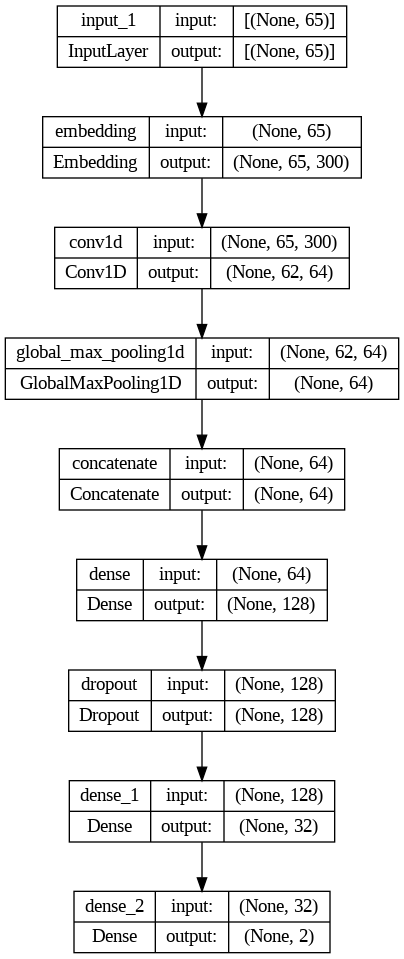

In [24]:
activation='relu'
kernel_sizes = [4]
conv_layers = []

input = Input(shape=(max_length,))
embedding = embedding_layer_fasttext(input)

for kernel_size in kernel_sizes:
  conv = Conv1D(64,kernel_size,activation=activation)(embedding)
  pool = GlobalMaxPool1D()(conv)
  conv_layers.append(pool)

merged = concatenate(conv_layers)
dense1 = Dense(128,activation=activation)(merged)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(32,activation=activation)(drop1)
predict = Dense(2,activation='softmax')(dense2)

model = Model(input,predict)

plot_model(model,to_file=drive_url+img_target+"text_cnn_model_structure.png", show_shapes=True)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65)]              0         
                                                                 
 embedding (Embedding)       (None, 65, 300)           8644500   
                                                                 
 conv1d (Conv1D)             (None, 62, 64)            76864     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 concatenate (Concatenate)   (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                             

# <center>TRAINING</center>

In [26]:
model_checkpoint = ModelCheckpoint(filepath=drive_url + model_checkpoint_target + 'textcnn_weights('+str(datetime.now().strftime("%Y-%m-%d"))+').h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1,
                                   save_weights_only=True)


early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

metrics = ['accuracy',F1Score(), AUC()]

metrics_history = {
    "loss": [],
    "accuracy": [],
    "f1_score": [],
    "auc": []
}


def on_batch_end(batch, logs):
    metrics_history["loss"].append(logs["loss"])
    metrics_history["accuracy"].append(logs["accuracy"])
    metrics_history["f1_score"].append(logs["accuracy"])
    metrics_history["auc"].append(logs["auc"])

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              metrics=metrics)

In [28]:
history = model.fit(Xtrain, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(Xval, y_val),
                    callbacks=[early_stopping,
                               model_checkpoint,
                               tf.keras.callbacks.LambdaCallback(on_batch_end=on_batch_end)],
                    shuffle=True)

Epoch 1/20
5400/5400 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9581 - f1_score: 0.9572 - auc: 0.9921
Epoch 1: val_loss improved from inf to 0.05573, saving model to /content/drive/MyDrive/LSTM-GRU-data/Model_checkpoint/textcnn_weights(2023-11-07).h5
5400/5400 [==============================] - 60s 8ms/step - loss: 0.1096 - accuracy: 0.9581 - f1_score: 0.9572 - auc: 0.9921 - val_loss: 0.0557 - val_accuracy: 0.9790 - val_f1_score: 0.9786 - val_auc: 0.9978
Epoch 2/20
5398/5400 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9833 - f1_score: 0.9829 - auc: 0.9981
Epoch 2: val_loss improved from 0.05573 to 0.04917, saving model to /content/drive/MyDrive/LSTM-GRU-data/Model_checkpoint/textcnn_weights(2023-11-07).h5
5400/5400 [==============================] - 50s 9ms/step - loss: 0.0472 - accuracy: 0.9833 - f1_score: 0.9829 - auc: 0.9981 - val_loss: 0.0492 - val_accuracy: 0.9823 - val_f1_score: 0.9819 - val_auc: 0.9980
Epoch 3/20
5390/5400

# <center>TESTING</center>

In [29]:
# model.load_weights(drive_url+model_checkpoint_target+"sentiment_analysis_weights(2023-11-01).h5")

In [30]:
result = model.evaluate(Xtest, y_test)

240/240 [==============================] - 1s 4ms/step - loss: 0.0615 - accuracy: 0.9818 - f1_score: 0.9815 - auc: 0.9965


In [31]:
df = pd.read_csv(drive_url + dataset_target + "real-data-500.csv", delimiter=";", encoding='ISO-8859-1')
cols = ['ID','text','label']
df.columns = cols
real_Xtest = df['text']
real_Ytest = df['label']
real_Ytest = to_categorical(y=real_Ytest, num_classes=2)

seq_realXtest = tokenizer.texts_to_sequences(real_Xtest)
real_Xtest = pad_sequences(sequences=seq_realXtest, maxlen=max_length, padding="post")

In [32]:
real_result = model.evaluate(real_Xtest, real_Ytest)

16/16 [==============================] - 0s 11ms/step - loss: 0.6192 - accuracy: 0.8220 - f1_score: 0.8195 - auc: 0.8994


# <center>VISUALIZE RESULT</center>

### <center>Over epoch</center>

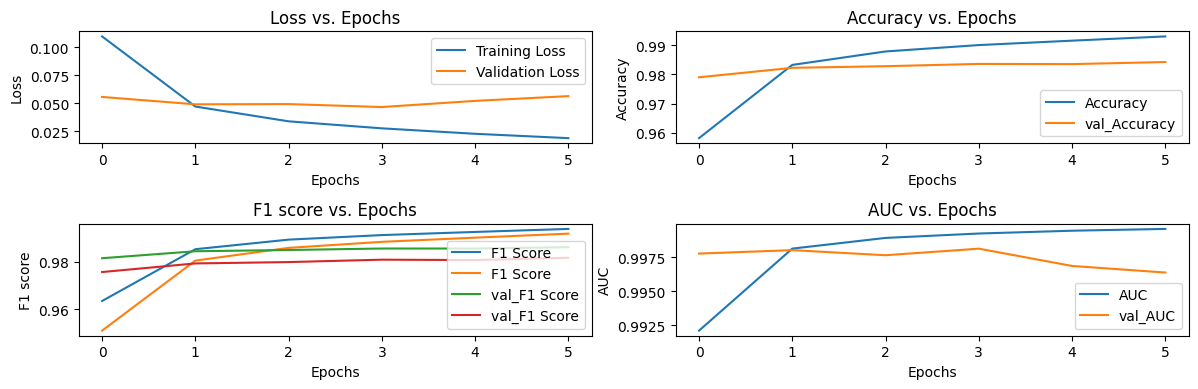

In [33]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
auc = history.history['auc']
val_auc = history.history['val_auc']

# loss
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy, Precision, Recall, F1_score, AUC on Epoch
plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='val_Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2,2,3)
plt.plot(f1, label='F1 Score')
plt.plot(val_f1, label='val_F1 Score')
plt.legend()
plt.title('F1 score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 score')

plt.subplot(2,2,4)
plt.plot(auc, label='AUC')
plt.plot(val_auc, label='val_AUC')
plt.legend()
plt.title('AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig(drive_url + img_target + 'textcnn_performance_over_epochs.png')
plt.show()

### <center>Over batch</center>

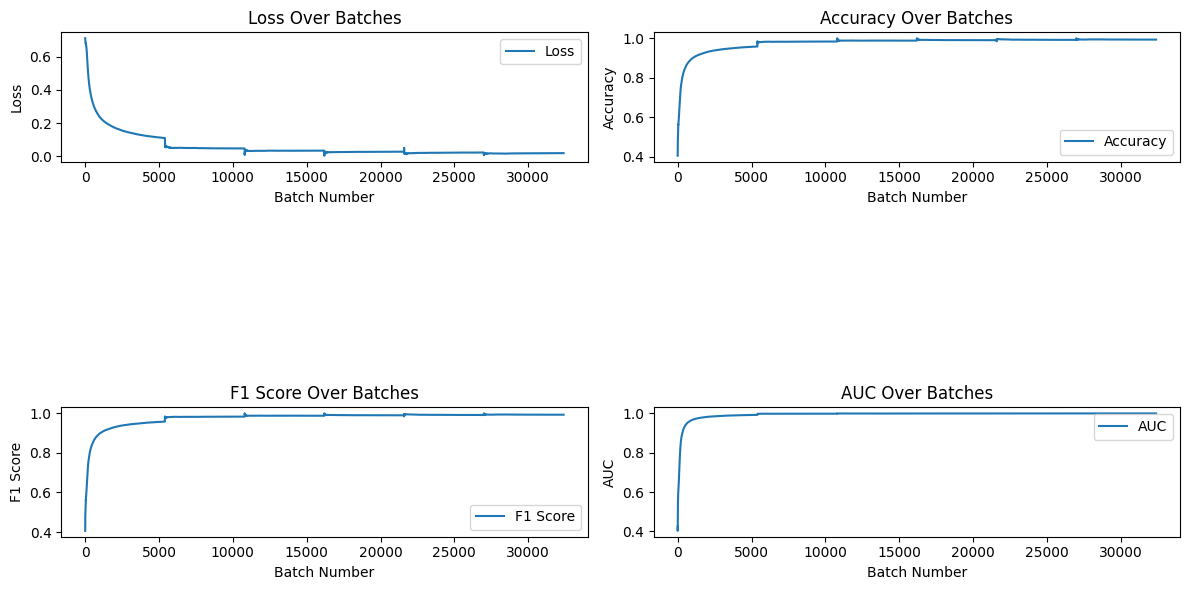

In [34]:
# loss
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.plot(metrics_history['loss'], label='Loss')
plt.title('Loss Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(3, 2, 2)
plt.plot(metrics_history['accuracy'], label='Accuracy')
plt.title('Accuracy Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()

# F1-score
plt.subplot(3, 2, 5)
plt.plot(metrics_history['f1_score'], label='F1 Score')
plt.title('F1 Score Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('F1 Score')
plt.legend()
# plt.show()

# AUC
plt.subplot(3, 2, 6)
plt.plot(metrics_history['auc'], label='AUC')
plt.title('AUC Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('AUC')
plt.tight_layout()
plt.legend()
plt.savefig(drive_url + img_target + 'textcnn_performance_over_batches.png')
plt.show()